<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Topic Modeling

by Fabian Märki

## Summary
The aim of this notebook is to get an understanding of [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html) provided by [gensim](https://radimrehurek.com/gensim). 

Topic Modeling has many usecases:
- understanding the different varieties topics in a corpus (obviously)
- getting a better insight into the type of documents in a corpus (whether they are about news, wikipedia articles, business documents)
- quantifying the most used / most important words in a corpus
- document similarity and recommendation.
- etc.

### Videos
Following videos provide a good introduction to LDA:
- [Latent Dirichlet Allocation](https://www.youtube.com/watch?v=T05t-SqKArY) (part 1)
- [Training Latent Dirichlet Allocation: Gibbs Sampling](https://www.youtube.com/watch?v=BaM1uiCpj_E) (part 2)
- [LDA Topic Models - turning words into meaning](https://www.youtube.com/watch?v=3mHy4OSyRf0) (builds a search engine using LDA as vectorizer)

### Sources
- https://www.kaggle.com/ktattan/lda-and-document-similarity
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models
- https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python
- https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

This notebook does not contain assigments: <font color='red'>Enjoy.</font>

<a href="https://colab.research.google.com/github/markif/2021_HS_CAS_NLP_LAB_Notebooks/blob/master/XX_b_Topic_Modeling.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [4]:
%%capture

!pip install 'fhnw-nlp-utils>=0.2.12,<0.3.0'

from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from fhnw.nlp.utils.system import system_info
print(system_info())

In [5]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")
data.shape

CPU times: user 7.79 s, sys: 1.36 s, total: 9.15 s
Wall time: 5.3 s


(350087, 10)

In [6]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [7]:
# remove all neutral sentimens
data = data.loc[(data["sentiment"] != 0)]
data.shape

(331187, 10)

Data preprocessing is key to success. Since LDA uses a bag of words model, the words used for the model matter a lot (i.e. happy ≠ happier or bank ≠ banks). This means that it is crutial that you do a proper text cleaning, e.g. by focusing on the word roots (lemmatization/stemming or use nouns or adjectives only - see also [here](https://www.youtube.com/watch?v=3mHy4OSyRf0&t=6m34s) for further inspiration). As a consequence, we reduce the total number of unique words in the dictionary and can expect to get better topics generated in the end.

LDA is a bag of words model, i.e. word order in a document does not count. This also means that stopwords and rare words should be excluded, so that the model does not overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.

In [8]:
!pip install nltk

import nltk
from nltk import FreqDist

# first get a list of all words
all_words = [word for item in data["token_lemma"] for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


165380

In [10]:
# choose k words and visually inspect the top/bottom 10 words
discard_words = set([word for word in fdist.keys() if fdist[word] < 88])
k = len(fdist) - len(discard_words)
top_k_words = fdist.most_common(k)
print("# k words:", k)
print("Top:", top_k_words[:10])
print("Bottom:", top_k_words[-10:])

# k words: 5880
Top: [('gut', 182684), ('nicht', 152071), ('praxis', 125493), ('nehmen', 110550), ('zeit', 103521), ('freundlich', 95712), ('arzt', 92293), ('immer', 89981), ('kompetent', 89230), ('behandlung', 85618)]
Bottom: [('hormonen', 88), ('harsch', 88), ('dioptrien', 88), ('qual', 88), ('weser', 88), ('brand', 88), ('wlan', 88), ('kessler', 88), ('klopf', 88), ('sasama', 88)]


In [12]:
# only consider the k words identified above
data["token_lemma_short"] = data["token_lemma"].apply(lambda x: [value for value in x if value not in discard_words])
print(len(set([word for item in data["token_lemma"] for word in item])))
print(len(set([word for item in data["token_lemma_short"] for word in item])))

165380
5880


Topic modeling (especially LDA) does not work well with very short documents (see [here](https://stackoverflow.com/questions/29786985/whats-the-disadvantage-of-lda-for-short-texts) and [here](https://www.semanticscholar.org/paper/A-biterm-topic-model-for-short-texts-Yan-Guo/b7da93b0c797cdb2b5b31adc73224d625c0a0759)). This is why you might want to drop short articles of a real world corpus (e.g. under 10 tokens). 
This is because the model infers parameters from observations and if there are not enough observations (words) in a document, the model performs poorly.

In [13]:
# document length
doc_lengths = list(data['token_lemma_short'].apply(lambda x: len(x)))

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 331187 
average document length 23.08698409055911 
minimum document length 0 
maximum document length 159


In [9]:
data[data["token_lemma_short"].apply(lambda x: len(x) <= 0)]

,text_original,rating,text,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords,token_lemma_short
1134,HERVORHAGEND::::::::::::::::::::::::::::::::::...,1.0,HERVORHAGEND,1,[hervorhagend],hervorhagend,[hervorhagend],[hervorhag],[hervorhagend],[]
1894,ist konsularisch im Marienkrankenhaus,2.0,ist konsularisch im Marienkrankenhaus,1,"[ist, konsularisch, im, marienkrankenhaus]",ist konsularisch im marienkrankenhaus,"[konsularisch, marienkrankenhaus]","[konsular, marienkrankenhaus]","[konsularisch, marienkrankenhaus]",[]
3699,Alles supi! :-),2.0,Alles supi!,1,"[alles, supi, !]",alles supi !,[supi],"[supi, !]","[supi, !]",[]
10065,Sehr zu empfehlene Arzr,1.0,Sehr zu empfehlene Arzr,1,"[sehr, zu, empfehlene, arzr]",sehr zu empfehlene arzr,"[empfehlene, arzr]","[empfehl, arzr]","[empfehlene, arzr]",[]
12852,Georg schöpplrin,1.0,Georg schöpplrin,1,"[georg, schöpplrin]",georg schöpplrin,"[georg, schöpplrin]","[georg, schopplrin]","[georg, schöpplrin]",[]
12874,Urlogie ist Einfühlungsvermögensache. Das hat ...,1.0,Urlogie ist Einfühlungsvermögensache. Das hat ...,1,"[urlogie, ist, einfühlungsvermögensache, ., da...",urlogie ist einfühlungsvermögensache . das hat...,"[urlogie, einfühlungsvermögensache, bewähren]","[urlogi, einfuhlungsvermogensach, ., bewahrt, .]","[urlogie, einfühlungsvermögensache, ., bewährt...",[]
19001,Sehr weiterzuempfehlem,1.0,Sehr weiterzuempfehlem,1,"[sehr, weiterzuempfehlem]",sehr weiterzuempfehlem,[weiterzuempfehlem],[weiterzuempfehl],[weiterzuempfehlem],[]
22380,Der weisst sehr viel,1.0,Der weisst sehr viel,1,"[der, weisst, sehr, viel]",der weisst sehr viel,[weisst],[weisst],[weisst],[]
24757,sehr Schlechtepersonal und arogant,5.0,sehr Schlechtepersonal und arogant,-1,"[sehr, schlechtepersonal, und, arogant]",sehr schlechtepersonal und arogant,"[schlechtepersonal, arogant]","[schlechtepersonal, arogant]","[schlechtepersonal, arogant]",[]
26420,Sehr emphehlenswert,1.0,Sehr emphehlenswert,1,"[sehr, emphehlenswert]",sehr emphehlenswert,[emphehlenswert],[emphehlenswert],[emphehlenswert],[]


In [10]:
data = data[~data["token_lemma_short"].apply(lambda x: len(x) <= 0)]

In [15]:
data[data["token_lemma_short"].apply(lambda x: len(x) >= 120)]

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords,token_lemma_short
262,"Ich hatte mir einen Termin geben lassen, da mi...",5.0,"Ich hatte mir einen Termin geben lassen, da mi...",negative,-1,"[ich, hatte, mir, einen, termin, geben, lassen...","ich hatte mir einen termin geben lassen , da m...","[termin, geben, lassen, jahre, weiblich, auffa...","[termin, geb, lass, ,, jahr, ,, weiblich, aufg...","[termin, geben, lassen, ,, jahre, ,, weiblich,...","[termin, geben, lassen, jahre, weiblich, auffa..."
345,Ich habe mir von Prof. Riederer die Nase korri...,1.0,Ich habe mir von Prof. Riederer die Nase korri...,positive,1,"[ich, habe, mir, von, prof., riederer, die, na...",ich habe mir von prof. riederer die nase korri...,"[prof, riederer, nase, korrigieren, lassen, wä...","[prof., ried, nas, korrigi, lass, warmst, empf...","[prof., riederer, nase, korrigieren, lassen, w...","[prof, nase, korrigieren, lassen, wärmstens, e..."
701,Ich war lange Jahre zufrieden mit Dr. Henneber...,6.0,Ich war lange Jahre zufrieden mit Dr. Henneber...,negative,-1,"[ich, war, lange, jahre, zufrieden, mit, dr., ...",ich war lange jahre zufrieden mit dr. henneber...,"[lang, jahre, zufrieden, henneberg, immer, fre...","[lang, jahr, zufried, dr., henneberg, imm, fre...","[lange, jahre, zufrieden, dr., henneberg, imme...","[lang, jahre, zufrieden, immer, freundlich, ko..."
748,Ich wurde direkt von meinem Hausarzt zum Hr.Dr...,5.0,Ich wurde direkt von meinem Hausarzt zum Hr Dr...,negative,-1,"[ich, wurde, direkt, von, meinem, hausarzt, zu...",ich wurde direkt von meinem hausarzt zum hr dr...,"[direkt, hausarzt, hr, adler, überweisen, sofo...","[wurd, direkt, hausarzt, hr, adl, uberwies, so...","[wurde, direkt, hausarzt, hr, adler, überwiese...","[direkt, hausarzt, hr, adler, überweisen, sofo..."
934,Ich trage seit etwa 1990 Einlagen. Vor etwa dr...,2.0,Ich trage seit etwa Einlagen. Vor etwa drei Ja...,positive,1,"[ich, trage, seit, etwa, einlagen, ., vor, etw...",ich trage seit etwa einlagen . vor etwa drei j...,"[tragen, seit, etwa, einlagen, etwa, drei, jah...","[trag, seit, etwa, einlag, ., etwa, drei, jahr...","[trage, seit, etwa, einlagen, ., etwa, drei, j...","[tragen, seit, etwa, einlagen, etwa, drei, jah..."
...,...,...,...,...,...,...,...,...,...,...,...
356721,Ich war aufgrund einer Empfehlung zu Dr Mahdi-...,1.0,Ich war aufgrund einer Empfehlung zu Dr Mahdi ...,positive,1,"[ich, war, aufgrund, einer, empfehlung, zu, dr...",ich war aufgrund einer empfehlung zu dr mahdi ...,"[aufgrund, empfehlung, mahdi, joest, kommen, v...","[aufgrund, empfehl, mahdi, joest, gekomm, ., v...","[aufgrund, empfehlung, mahdi, joest, gekommen,...","[aufgrund, empfehlung, mahdi, joest, kommen, v..."
356723,Auch ich hatte mir bei Herrn Dr. Mahdi-Joest d...,1.0,Auch ich hatte mir bei Herrn Dr. Mahdi Joest d...,positive,1,"[auch, ich, hatte, mir, bei, herrn, dr., mahdi...",auch ich hatte mir bei herrn dr. mahdi joest d...,"[mahdi, joest, nasenscheidewand, operieren, la...","[dr., mahdi, joest, nasenscheidewand, operi, l...","[dr., mahdi, joest, nasenscheidewand, operiere...","[mahdi, joest, nasenscheidewand, operieren, la..."
356726,Ich möchte hier kurz über das Procedere meiner...,1.0,Ich möchte hier kurz über das Procedere meiner...,positive,1,"[ich, möchte, hier, kurz, über, das, procedere...",ich möchte hier kurz über das procedere meiner...,"[mögen, kurz, procedere, ästhetisch, nasenkorr...","[mocht, kurz, proced, asthet, nasenkorrektur, ...","[möchte, kurz, procedere, ästhetischen, nasenk...","[mögen, kurz, procedere, ästhetisch, nasenkorr..."
356727,Dr. Mahdi-Joest hat Anfang Januar 2016 meine...,1.0,Dr. Mahdi Joest hat Anfang Januar meine Nasens...,positive,1,"[dr., mahdi, joest, hat, anfang, januar, meine...",dr. mahdi joest hat anfang januar meine nasens...,"[mahdi, joest, anfang, januar, nasenscheidewan...","[dr., mahdi, joest, anfang, januar, nasenschei...","[dr., mahdi, joest, anfang, januar, nasenschei

# Nuber of Topics

Topic modeling is an unsupervised technique, meaning that we do not know prior to running the model how many topics exits in our corpus. Topic coherence is one of the main techniques used to estimate the number of topics (see [CoherenceModel](https://radimrehurek.com/gensim/models/coherencemodel.html)). There are several measures available to calculate the coherence score. Alternatively, one can also use visualization tools (like pyLDAvis for LDA), or tried a few numbers of topics and compare the results by hand.

We need to build many models with different number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

# LDA

Latent Dirichlet Allocation, is an unsupervised generative model that assigns topic distributions to documents.

At a high level, the model assumes that each document will contain several topics, so that there is topic overlap within a document. The words in each document contribute to these topics. There can be words overlap between topics, so several topics may share the same words. The topics may not be known and do not need to be specified a priori, but the number of topics must be specified a priori. 

After training, each document will have a discrete distribution over all topics, and each topic will have a discrete distribution over all words. I.e. the model generates following latent (hidden) variables: 
- A distribution over topics for each document
- A distribution over words for each topics

### Hyperparameters

LDA has 2 hyperparameters: α and η

α: A low value for α means that documents have only a low number of topics contributing to them. A high value of α yields the inverse, meaning the documents appear more alike within a corpus.

η: A low value for η means the topics have a low number of contributing words. A high value of η yields the inverse, meaning topics will have word overlap and appear more alike.

The values of α and η depend on the application, and may need to be tweaked several times before the desired results are found. [Gensim's implementation](https://radimrehurek.com/gensim/models/ldamodel.html) allows to use `auto` in order to learn an asymmetric prior from the corpus. In addition, there is also a [multicore implementation](https://radimrehurek.com/gensim/models/ldamulticore.html) available.  

## LDA - Nuber of Topics

Lets perform a hyper-parameter tuning in order to find the optimal number of topics.

In [16]:
!pip install gensim

import time
from matplotlib import pyplot as plt
import gensim
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel


def compute_coherence_values(texts, model, coherence='c_v'):
    """
    Compute coherence of a model

    Parameters:
    ----------
    model : The topic model
    coherence: The coherence measure to be used

    Returns:
    -------
    coherence_value : Coherence value corresponding to the model with respective number of topics
    """

    coherencemodel = CoherenceModel(model=model, texts = texts, corpus=corpus, dictionary=dictionary, coherence=coherence)

    return coherencemodel

def show_coherence_graph(start, limit, step, coherence_values, coherence_names):
    # Show graph
    x = range(start, limit, step)
    fig, axs = plt.subplots(len(coherence_values))
    
    for i, coherence_name in enumerate(coherence_names):
        coherence_vals = coherence_values[coherence_name]
        axs[i].plot(x, coherence_vals)
        axs[i].set_xlabel("Num Topics")
        axs[i].set_ylabel("Coherence Value")
        axs[i].legend((coherence_name), loc='best')

    plt.show()

def train_lda(data, num_topics = 10, alpha='auto', eta='auto'):
    """
    This function trains the lda model
    We setup parameters like number of topics
    """
    #chunksize = 300
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(doc) for doc in data]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    # alpha=1e-2, eta=0.5e-2,
    # , per_word_topics=True, , minimum_probability=0.0
    chunksize = 20
    passes=30
    if alpha is 'auto':
        lda = LdaModel(alpha=alpha, eta=eta, corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, passes=passes)
    else:
        lda = LdaMulticore(alpha=alpha, eta=eta, corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, passes=passes, workers=6)
        
    t2 = time.time()
    print("Time to train a", num_topics, "topics LDA model on", len(data), "articles:", (t2-t1)/60, "min")
    return lda,dictionary,corpus

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
from sklearn.model_selection import train_test_split

# ensure we retain the class weights
data_train, data_test = train_test_split(data, test_size=1.0-2000.0/data.shape[0], random_state=42, stratify=data["sentiment"])

Time to train a 2 topics LDA model on 2000 articles: 0.1466920018196106 min
Time to train a 3 topics LDA model on 2000 articles: 0.1663592259089152 min
Time to train a 4 topics LDA model on 2000 articles: 0.17237621943155926 min
Time to train a 5 topics LDA model on 2000 articles: 0.1745077848434448 min
Time to train a 6 topics LDA model on 2000 articles: 0.15321063995361328 min


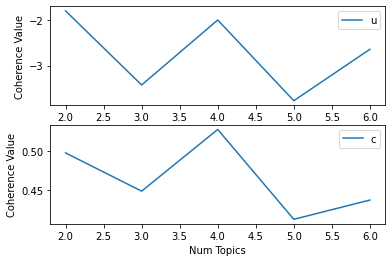

In [18]:
start=2
limit=7
step=1
coherences = ['u_mass', 'c_v']
alpha = 0.2 #"auto"
# dic of lists
coherence_values = {}
for coherence in coherences:
    coherence_values[coherence] = []
model_list = []
texts = data_train["token_lemma_short"]

for num_topics in range(start, limit, step):
    model,dictionary,corpus = train_lda(texts, num_topics = num_topics, alpha=alpha)
    model_list.append((model,dictionary,corpus))
    
    for coherence in coherences:
        coherencemodel = compute_coherence_values(texts, model, coherence)
        coherence_values[coherence].append(coherencemodel.get_coherence())
    
show_coherence_graph(start, limit, step, coherence_values, coherences) 

Topic modeling on the complete corpus. Set the number of topics to 2 since we do a sentiment analysis (pos/neg).

In [19]:
%%time
num_topics = 2
model,dictionary,corpus = train_lda(data["token_lemma_short"], num_topics = num_topics, alpha=alpha)

Time to train a 2 topics LDA model on 331187 articles: 15.194965422153473 min
CPU times: user 15min 21s, sys: 1min 47s, total: 17min 8s
Wall time: 15min 26s


Store the model since it took quite a while. 

In [22]:
from fhnw.nlp.utils.storage import get_path
from pathlib import Path

lda_model_path = "data/german_doctor_reviews_lda/lda_german_doctor_reviews"
parent_path = get_path(lda_model_path)
Path(parent_path).mkdir(parents=True, exist_ok=True)
model.save(lda_model_path)

Option to restart from a prepared model.

In [29]:
#model=None
if model is None:
    import zipfile
        
    download("https://drive.google.com/uc?id=1hmesXEflGpIaE22g9E9K2_A9JlG6fwY8", "data/german_doctor_reviews_lda.zip")

    with zipfile.ZipFile("data/german_doctor_reviews_lda.zip", 'r') as zip_ref:
        zip_ref.extractall("data")
    
    model = LdaModel.load("data/german_doctor_reviews_lda/lda_german_doctor_reviews")

Let's inspect some topics. When we see the words they may seem shortened. This is because of our lemmanized/stemmed the words.

Note that if you re run the model again, as it is non-deterministic, word contributions to topics and topic ID's will change.

In a LDA model, a topic is defined as a distribution over the vocabulary. In the list below this refers to the $\lambda_k$/$\beta_k$ variable and this is displayed by "show_topics()". Show_topics allows to specify the number of topics by parameter "num_topics" and also the number of words per topic by parameter "num_topics". So not the whole vocabulary is displayed but only those with the highest probability under a certain topic.

In [33]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
model.show_topics(num_topics=num_topics, num_words=20)

[(0,
  '0.037*"nicht" + 0.013*"termin" + 0.012*"arzt" + 0.010*"praxis" + 0.009*"kommen" + 0.009*"gehen" + 0.008*"mal" + 0.007*"gut" + 0.007*"op" + 0.007*"bekommen" + 0.007*"schon" + 0.006*"mehr" + 0.006*"warten" + 0.006*"sagen" + 0.006*"behandlung" + 0.006*"schmerzen" + 0.006*"geben" + 0.005*"leider" + 0.005*"lang" + 0.005*"erst"'),
 (1,
  '0.039*"gut" + 0.023*"nehmen" + 0.023*"freundlich" + 0.023*"praxis" + 0.022*"kompetent" + 0.021*"zeit" + 0.018*"immer" + 0.017*"fühlen" + 0.016*"behandlung" + 0.013*"arzt" + 0.012*"team" + 0.011*"empfehlen" + 0.010*"zufrieden" + 0.010*"patienten" + 0.010*"seit" + 0.009*"aufheben" + 0.009*"nett" + 0.009*"jahren" + 0.008*"super" + 0.007*"ärztin"')]

pyLDAVis is a nice way to visualise the information contained in a topic model.

In [34]:
!pip install "pyLDAvis==3.2.2"

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [35]:
%%time

import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=model.id2word)
vis

CPU times: user 1min 2s, sys: 373 ms, total: 1min 3s
Wall time: 1min 4s


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.134578  0.0       1        1  53.085093
0     -0.134578  0.0       2        1  46.914907, topic_info=           Term           Freq          Total Category  logprob  loglift
62        nicht  149884.000000  149884.000000  Default  30.0000  30.0000
73    kompetent   88718.000000   88718.000000  Default  29.0000  29.0000
116  freundlich   95956.000000   95956.000000  Default  28.0000  28.0000
55          gut  184022.000000  184022.000000  Default  27.0000  27.0000
125      fühlen   71036.000000   71036.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
16    behandeln   14161.668754   35784.216817   Topic2  -5.5346  -0.1701
141      ärztin   14757.333095   43625.246922   Topic2  -5.4934  -0.3271
44         zeit   16360.944170  102554.331318   Topic2  -5.3902  -1.0787
41       nehmen   15695.335010  108481.344265   Topic2  -5.4318  -1.1764
70        immer   13207.535749   86832.952851   Topic2  -5.6043  -1.1264

[160 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1329      1  0.000179   allerdings
1329      2  0.999957   allerdings
348       1  0.999950     angenehm
348       2  0.000061     angenehm
14        1  0.551973         arzt
...     ...       ...          ...
439       2  0.000162  zuvorkommen
141       1  0.661727       ärztin
141       2  0.338267       ärztin
789       1  0.000169    überhaupt
789       2  0.999847    überhaupt

[232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

<font color='red'>**Question: What is the meaning of the adjustable lambda scroll bar and what does it control?**</font>

<font color='green'>At abstract level the lambda bar let you filter out non-representative words that are highly associated with the topic that you have selected (topics can be selected in the upper left corner). By moving lambda you can balance the listing of words that are important to your topic in general (but that might not be exclusively used in the context of that particular topic) and words that are only associated to a larger degree with that specific topic. So low lambda will choose exclusive words (e.g. some specific slang words) and larger lambda  will choose that are in general important to your (and possibly other) topics.</font>

<font color='red'>**Question: What do the blue and red bars indicate?**</font>

<font color='green'>A word with a larger blue bar is generally found in many topics (as it would have a high overall term frequency) and a words with a red bar is more exclusively associated with that particular topic you are analyzing.</font>

<font color='blue'>If you are familiar with the subject of the articles in this dataset, you can judge if the topics above make sense. However, they might not be without flaws. There might be substantial overlap between some topics, others are hard to interpret, and most of them have at least some terms that seem out of place.</font>

<font color='blue'>There are also other approaches to evaluate Topic Models such as [Perplexity](https://en.wikipedia.org/wiki/Perplexity). Topic Visualization is also a good way to assess topic models. [Topic Coherence](https://stackoverflow.com/a/55816086) measure is a good way to compare difference topic models based on their human-interpretability. The aim of the Coherence measure (e.g. u_mass or c_v) is to capture the optimal number of topics by giving the interpretability of these topics.</font>